[323860.5034732646, 323907.4350206611, 323954.3665680575, 324001.29811545403, 324048.2296628505, 324095.16121024697, 324142.09275764343, 324189.0243050399, 324235.95585243637, 324282.88739983283, 324329.81894722936, 324376.75049462577, 324423.6820420223, 324470.61358941876, 324517.5451368152, 324564.4766842117, 324611.40823160816, 324658.3397790047, 324705.2713264011, 324752.2028737976, 324799.13442119403, 324846.06596859056, 324892.997515987, 324939.9290633835, 324986.86061077996, 325033.79215817695, 325080.7237055734, 325127.65525296994, 325174.58680036635, 325221.5183477629, 325268.4498951593, 325315.3814425558, 325362.3129899523, 325409.24453734874, 325456.1760847452, 325503.1076321417, 325550.0391795382, 325596.9707269346, 325643.90227433114, 325690.83382172755, 325737.76536912407, 325784.69691652054, 325831.628463917, 325878.5600113135, 325925.49155870994, 325972.42310610646, 326019.3546535029, 326066.2862008994, 326113.2177482958, 326160.14929569233]
simulated data csv success!


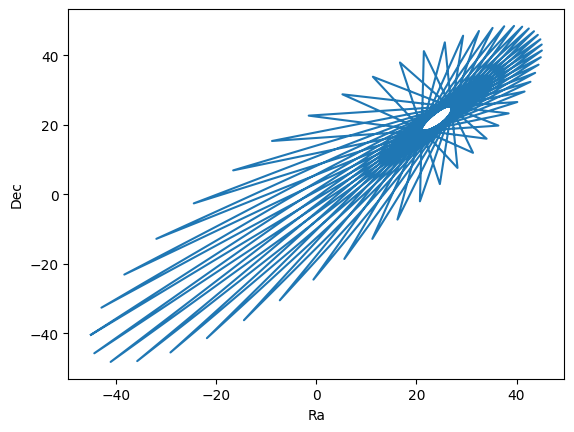

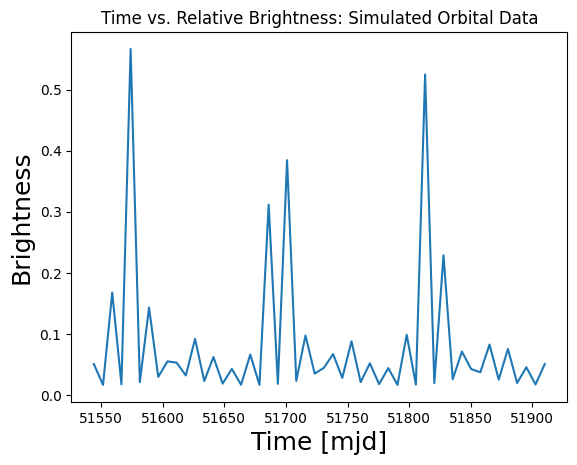

In [ ]:
# Toy Model: Converting orbital elements to position
import numpy as np
import math
import matplotlib.pyplot as plt
from astropy.time import Time

# orbit values
r = 50 # [mas]
e = 0.3
inc = np.radians(30) # [radians]
Omega = np.radians(60) # [radians]
omega = np.radians(120) # [radians]
plx = 30 # [mas]
albedo= 0.5
tau_ref_epoch = 0 # [mjd]
# the semimajor axis (a) that is implied here is 1.5au

# First define functions:

#Here will be the function where we convert time to mean anomaly; we will convert these 5 values:
# time_values = np.linspace(0, 1, num=50) # [time_values are in years]
time_values = Time(np.linspace(2000, 2001, num=50), format='decimalyear')

# We can begin defining the conversion and its variables
# t0 is time since periapsis (when its closest to the star) (years), t is the current time, T is orbital period (in years), a is semi-major axis (in au)
def time_to_mean_anomaly(t, t0, T):
   

# This is the equation to go from time to mean anomaly
   mean_anomaly = (2 * math.pi * (t-t0 - tau_ref_epoch)/T)
   return mean_anomaly
    

T = 365
t0 = 0
mean_anomalies = []
for i in time_values.mjd:
    mean_anomaly = time_to_mean_anomaly(i, t0, T)
    mean_anomalies.append(mean_anomaly)

print(mean_anomalies)

# print out the final answer as a statement
#for i, mean_anomaly in enumerate(mean_anomalies):
    #print(f"Time: {time_values[i]} degrees --> Mean Anomaly: {math.degrees(mean_anomaly)} degrees --> Eccentric Anomaly: {math.degrees(Ecc_anomalies_list[i])} degrees")


# Define mean anomaly to eccentric anomaly
def mean_to_eccentric(mean_anomaly, e):
    #Here is where we convert from mean anomaly to eccentric anomanly
    E = mean_anomaly

# Solution to keplers equation is below: M = E - e * sin(E), which turns into f(E) = M + e *sin(E)
    max_iterations = 50
    tolerance = 1e-9

    for _ in range(max_iterations):

        E_new = E - (E - e * np.sin(E) - mean_anomaly) / (1 - e * np.cos(E))
        if abs(E_new - E) < tolerance:
            break
        E = E_new
        

    return E
Ecc_anomalies_list = []
for i in mean_anomalies:
    E =  mean_to_eccentric(i,e)
    Ecc_anomalies_list.append(E)
#print("These are the eccentric anomalies:", Ecc_anomalies_list)

# Convert from eccentric anomaly to true anomaly
def eccentric_to_true(E, e):

# Calculate tan(f/2)
    tan_f_over_2 = math.sqrt((1 + e) / (1 - e)) * math.tan(E / 2)
    
    # Calculate ν
    f = 2 * math.atan(tan_f_over_2)
    
    #make sure nu is within [0, 2π)
    if f < 0:
        f += 2 * math.pi
    
    return f
true_anomalies = []
for i in Ecc_anomalies_list:
    f = eccentric_to_true(i, e)
    true_anomalies.append(f)
#print("These are the true anomalies:", true_anomalies)

#print("These are the orbital positions:", orbital_elements_and_true_anomaly_to_positions)

def orbital_elements_and_true_anomaly_to_positions(f, r, e,inc, Omega, omega, plx, albedo):
    # Write the converting function
    # ra & dec should be in units of milliarcseconds (mas)
    # r should also be mas
    # Omega, omega, f, and inc should all be in radians.
    ra = r*(np.cos(Omega)*np.cos(omega + f) - np.sin(Omega)*np.sin(omega + f)*np.cos(inc))
    dec = r*(np.sin(Omega)*np.cos(omega + f) - np.cos(Omega)*np.sin(omega + f)*np.cos(inc))

    plx_in_arcsec = plx * 1e-3
    a = plx_in_arcsec*r # [au]

    print(a)
    
    
    R = (a*(1-e**2))/(1+e*np.cos(f))
        
    z = R*(-np.cos(omega)*np.sin(inc)*np.sin(f)-np.cos(f)*np.sin(inc)*np.sin(omega))
        
    ro = (z**2+((ra**2+dec**2)/plx**2))**0.5
        
    B = math.atan2(-ro, z)+ math.pi
        
    A = (1/math.pi)*(np.sin(B)+(math.pi-B)*np.cos(B))
        
    brightness = albedo*A/ro**2
        
    return ra, dec, brightness


oe_to_pos_ra = []
oe_to_pos_dec = []
brightness_new = []
for i in true_anomalies:
    ra, dec, brightness = orbital_elements_and_true_anomaly_to_positions(i, r, e, inc, Omega, omega, plx, albedo)

    oe_to_pos_ra.append(ra)
    oe_to_pos_dec.append(dec)
    brightness_new.append(brightness)

#print("These are the true anomalies:", true_anomalies)

#print("These are the orbital positions:", orbital_elements_and_true_anomaly_to_positions)

#print("These are the orbital positions!", oe_to_pos)

# print out the final answer as a statement
#for i, mean_anomaly in enumerate(mean_anomalies):
    #print(f"Time: {time_values[i]} degrees --> Mean Anomaly: {math.degrees(mean_anomaly)} degrees --> Eccentric Anomaly: {math.degrees(Ecc_anomalies_list[i])} degrees")

# Now lets plot the ra and dec values
#print(oe_to_pos_ra)
#print(oe_to_pos_dec)

plt.figure()
plt.plot(oe_to_pos_ra, oe_to_pos_dec)
plt.xlabel('Ra')
plt.ylabel('Dec')

plt.figure()
plt.plot(time_values.mjd, brightness_new)
plt.xlabel("Time [mjd]", fontsize=18)
plt.ylabel("Brightness", fontsize=18)
plt.title("Time vs. Relative Brightness: Simulated Orbital Data")

import csv

# Assuming you already have ra, dec, brightness, and time (as epoch)
# oe_to_pos_ra, oe_to_pos_dec, brightness_new, and time_values lists exist

#CSV file name
#filename = "/Users/farrahamolina/orbitize/orbitize/example_data/orbital_data_with_id.csv"
# filename = "/Users/farrahamolina/orbitize/orbitize/example_data/simulated_ra_dec_data.csv"
filename = "simulated_ra_dec_data.csv"
Object_ID_List = [1] * 50
raoff_err_list = [0.01] * 50
decoff_err_list = [0.01] * 50

#with open(filename, mode='w', newline='') as file:
 #   writer = csv.writer(file)

    # Write the header with the additional "object_id" column
  #  writer.writerow(["epoch", "object", "raoff", "decoff", "raoff_err", "decoff_err", "brightness"])

    # Write the data rows with a unique ID for each object
   # for (epoch, obj, ra, dec, raoff_err, decoff_err, brightness) in (zip(time_values, Object_ID_List, oe_to_pos_ra, oe_to_pos_dec, raoff_err_list, decoff_err_list,  brightness_new)):
    #    writer.writerow([epoch, obj, ra, dec, raoff_err,decoff_err, brightness])

#print("csv file success!!")

with open(filename, mode='w', newline='') as file:
    writer = csv.writer(file)

    # Write the header with the additional "object_id" column
    writer.writerow(["epoch", "object", "raoff", "decoff", "raoff_err", "decoff_err"])

    # Write the data rows with a unique ID for each object
    for (epoch, obj, ra, dec, raoff_err, decoff_err) in (zip(time_values, Object_ID_List, oe_to_pos_ra, oe_to_pos_dec, raoff_err_list, decoff_err_list)):
        writer.writerow([epoch.mjd, obj, ra, dec, raoff_err,decoff_err])

print("simulated data csv success!")